In [1]:
# Пятая нейросеть. CNN для цветных изображений разного размера. Улучшение качества обучения

# Импорт всего важного
from __future__ import absolute_import, division, print_function, unicode_literals
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.models import load_model
import tensorflow_datasets as tfds
import math
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Создание переменных путей

_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
zip_dir = tf.keras.utils.get_file('cats_and_dogs_filterted.zip', origin=_URL, extract=True)

zip_dir_base = os.path.dirname(zip_dir)

base_dir = os.path.join(os.path.dirname(zip_dir), 'cats_and_dogs_filtered')
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

train_cats_dir = os.path.join(train_dir, 'cats')
train_dogs_dir = os.path.join(train_dir, 'dogs')
validation_cats_dir = os.path.join(validation_dir, 'cats')
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

num_cats_tr = len(os.listdir(train_cats_dir))
num_dogs_tr = len(os.listdir(train_dogs_dir))
num_cats_val = len(os.listdir(validation_cats_dir))
num_dogs_val = len(os.listdir(validation_dogs_dir))
total_train = num_cats_tr + num_dogs_tr
total_val = num_cats_val + num_dogs_val

In [3]:
# Функция, которая возвращает изображения со случайными преобразованиями
# Нужна для расширения тестовых данных

def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()

In [4]:
BATCH_SIZE = 100 # Количество тренировочных изображений для обработки перед обновлением параметров модели
IMG_SHAPE = 150 # Размерность 150x150 к которой будет преведено входное изображение

# Приведение с помощью ImageDataGenerator изображений к тензорам с плавающей запятой
# А также нормализация изображений (переход от формата [0; 255] к формату [0; 1])
train_image_generator = ImageDataGenerator(rescale=1./255, rotation_range=40, width_shift_range=0.2,
                                           height_shift_range=0.2, shear_range=0.2, zoom_range=0.2,
                                           horizontal_flip=True, fill_mode='nearest')
validation_image_generator = ImageDataGenerator(rescale=1./255)

# Загрузка данных
# Сначала тренировочные данные
train_data_gen = train_image_generator.flow_from_directory(batch_size=BATCH_SIZE,
                                                          directory=train_dir,
                                                          shuffle=True,
                                                          target_size=(IMG_SHAPE,IMG_SHAPE),
                                                          class_mode='binary')

# Затем валидационные данные
val_data_gen = validation_image_generator.flow_from_directory(batch_size=BATCH_SIZE,
                                                              directory=validation_dir,
                                                              shuffle=False,
                                                              target_size=(IMG_SHAPE,IMG_SHAPE),
                                                              class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


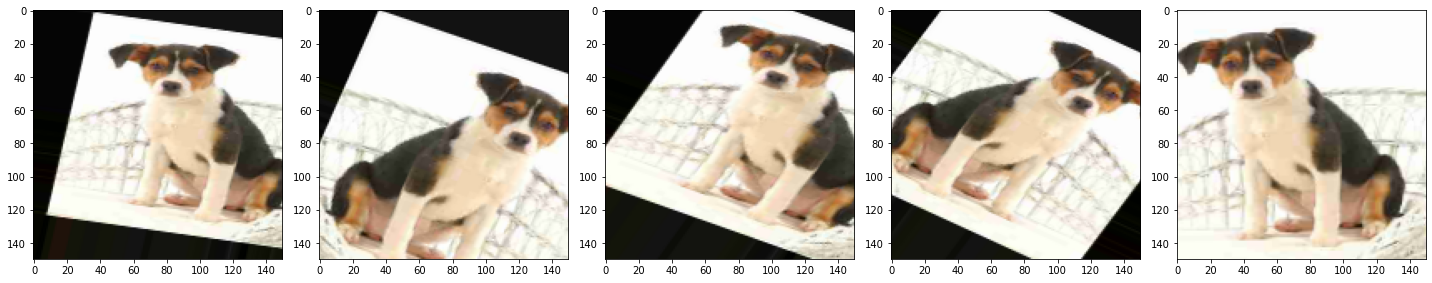

In [5]:
# Преобразования в действии

augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

In [6]:
# Создание модели
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(IMG_SHAPE, IMG_SHAPE, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Dropout(0.5), # Dropout-слой, отключающий половину случайных нейронов
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(2, activation='softmax')
])

# Компиляция модели
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Представление модели
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 128)       1

In [7]:
# Тренировка моделей
EPOCHS = 100
history = model.fit_generator( # Используется fit_generator вместо обычного fit
    train_data_gen,
    steps_per_epoch=int(np.ceil(total_train / float(BATCH_SIZE))),
    epochs=EPOCHS,
    validation_data=val_data_gen,
    validation_steps=int(np.ceil(total_val / float(BATCH_SIZE)))
)

Epoch 1/100
20/20 [==============================] - 16s 782ms/step - loss: 0.5245 - accuracy: 0.7395 - val_loss: 0.5333 - val_accuracy: 0.7280
Epoch 2/100
20/20 [==============================] - 16s 781ms/step - loss: 0.5151 - accuracy: 0.7375 - val_loss: 0.4993 - val_accuracy: 0.7500
Epoch 3/100
20/20 [==============================] - 16s 784ms/step - loss: 0.5127 - accuracy: 0.7415 - val_loss: 0.4898 - val_accuracy: 0.7620
Epoch 4/100
20/20 [==============================] - 16s 786ms/step - loss: 0.4971 - accuracy: 0.7495 - val_loss: 0.5125 - val_accuracy: 0.7400
Epoch 5/100
20/20 [==============================] - 16s 778ms/step - loss: 0.5142 - accuracy: 0.7445 - val_loss: 0.4788 - val_accuracy: 0.7600
Epoch 6/100
20/20 [==============================] - 16s 780ms/step - loss: 0.5120 - accuracy: 0.7435 - val_loss: 0.4990 - val_accuracy: 0.7490
Epoch 7/100
20/20 [==============================] - 16s 783ms/step - loss: 0.4925 - accuracy: 0.7605 - val_loss: 0.4721 - val_accuracy:

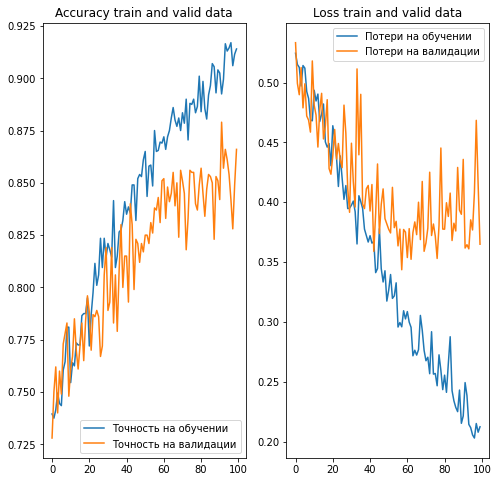

In [8]:
# Визуализация результатов тренировки
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8,8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Точность на обучении')
plt.plot(epochs_range, val_acc, label='Точность на валидации')
plt.legend(loc='lower right')
plt.title('Accuracy train and valid data')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Потери на обучении')
plt.plot(epochs_range, val_loss, label='Потери на валидации')
plt.legend(loc='upper right')
plt.title('Loss train and valid data')
plt.show()

In [8]:
# Сохраняем модель
model.save('Fifth_network_CNN_model.h5')